Import Library

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

input File Data

In [ ]:
data = pd.read_excel('./Femicide in Indonesia.xlsx')

Konversi Kolom Menjadi Tipe Datetime

In [ ]:
data['bln/tahun'] = pd.to_datetime(data['bln/tahun'], errors='coerce', dayfirst=True)
data = data.dropna(subset=['bln/tahun'])

<ipython-input-3-2280e33887be>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['bln/tahun'] = pd.to_datetime(data['bln/tahun'], errors='coerce', dayfirst=True)


Pembersihan Data, Analisis Statistik, Analisis Subset Data

In [ ]:
data['umur'] = pd.to_numeric(data['umur'], errors='coerce')
data = data.dropna(subset=['umur'])
average_age = data['umur'].mean()

most_common_perpetrator = data['Pembunuh Oleh'].mode()[0]
most_common_reason = data['Alasan Pembunuh 1'].mode()[0]

monthly_cases = data.groupby(data['bln/tahun'].dt.to_period("M")).size()
average_cases_per_month = monthly_cases.mean()

male_data = data[data['Pembunuh Oleh'].str.contains('Suami|Pacar|Pria', na=False)]
most_common_reason_male = male_data['Alasan Pembunuh 1'].mode()[0]

Menampilkan Hasil

In [ ]:
print(f"Average victim age: {average_age}")
print(f"Most common perpetrator: {most_common_perpetrator}")
print(f"Most common reason for murder: {most_common_reason}")
print(f"Average cases per month: {average_cases_per_month}")
print(f"Most common reason for male perpetrators: {most_common_reason_male}")


Average victim age: 35.476190476190474
Most common perpetrator: Suami
Most common reason for murder: Perselingkuhan
Average cases per month: 4.2
Most common reason for male perpetrators: Cemburu


In [ ]:
monthly_cases.index = monthly_cases.index.to_timestamp()

# Fit ARIMA model
model = ARIMA(monthly_cases, order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [ ]:
forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=monthly_cases.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-13-fba8813b9756>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_cases.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


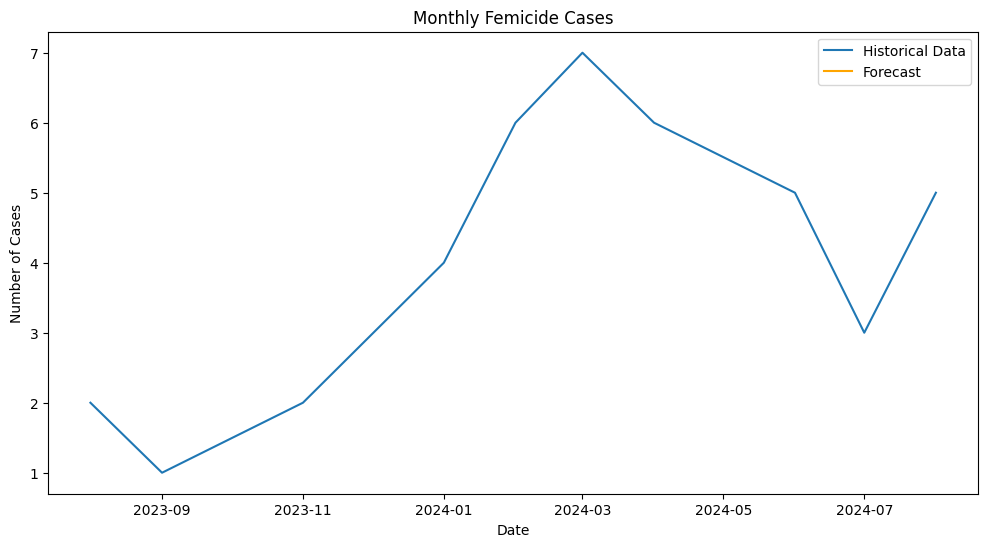

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_cases, label='Historical Data')
plt.plot(forecast_series, label='Forecast', color='orange')
plt.title('Monthly Femicide Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

In [ ]:
!pip install statsmodels

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

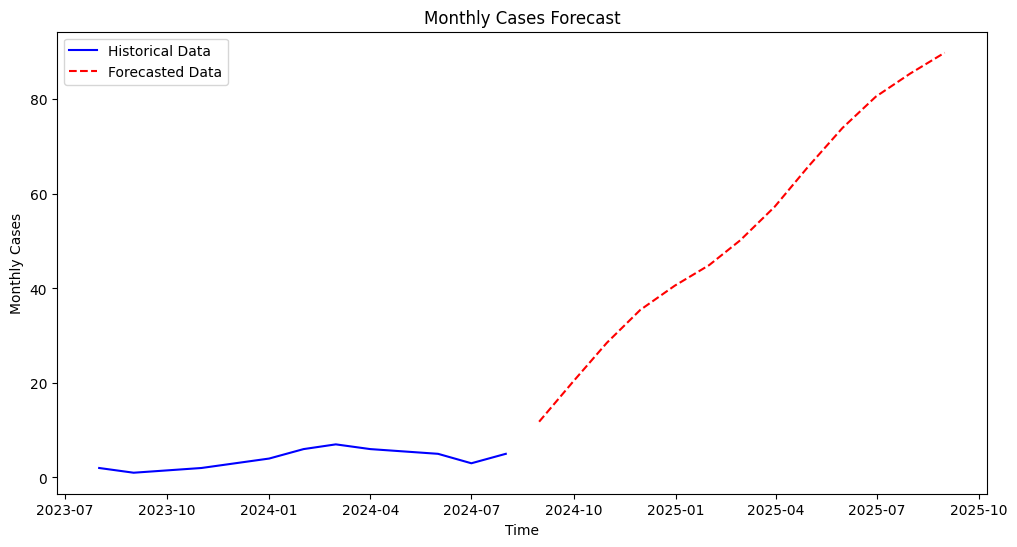

Forecasted Values Table:
            Forecasted Monthly Cases
2024-08-31                 11.791354
2024-09-30                 20.113030
2024-10-31                 28.500903
2024-11-30                 35.441291
2024-12-31                 40.561486
2025-01-31                 44.920925
2025-02-28                 50.175539
2025-03-31                 57.274409
2025-04-30                 65.714563
2025-05-31                 73.939023
2025-06-30                 80.563105
2025-07-31                 85.463124
2025-08-31                 89.871513


In [ ]:


from statsmodels.tsa.stattools import adfuller


adf_test = adfuller(monthly_cases)


if adf_test[1] > 0.05:
    monthly_cases_diff = monthly_cases.diff().dropna()
else:
    monthly_cases_diff = monthly_cases


model = ARIMA(monthly_cases_diff, order=(2, 1, 2))
model_fit = model.fit()


forecast_diff = model_fit.forecast(steps=13)


forecast_index = pd.date_range(start=monthly_cases.index[-1], periods=13, freq='M')


forecast_values = monthly_cases.iloc[-1] + forecast_diff.cumsum()
forecast_series = pd.Series(forecast_values.values, index=forecast_index)


plt.figure(figsize=(12, 6))
plt.plot(monthly_cases, label='Historical Data', color='blue')
plt.plot(forecast_series, label='Forecasted Data', color='red', linestyle='--')

plt.title('Monthly Cases Forecast')
plt.xlabel('Time')
plt.ylabel('Monthly Cases')
plt.legend()
plt.show()

forecast_table = pd.DataFrame({
    'Forecasted Monthly Cases': forecast_series
})
print("Forecasted Values Table:")
print(forecast_table)